# Kinematic analysis of J0218-00

Author: [Kiara Hervella](https://www.linkedin.com/in/kiara-hervella/)

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10',8)
sns.set_style('whitegrid')
import numpy as np

from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.analysis import line_flux

import astropy.units as u
from astropy.table import QTable, Table
from astropy.io import ascii

from tied_parameters import *
from aux_functions import *

In [2]:
# Function for saving the results from the code
def table_add_model(line_combo_fit,t): 
  ncomps = line_combo_fit.n_submodels
  if ncomps > 1:
    for i in range(ncomps):
      t.add_row(line_tab[i])
  else:
    t.add_row(line_tab)
  return t

In [3]:
# Import the information about the targets
targets_info = ascii.read('../spectra/targets_info_complete.csv')

# Choosing a target
tgt_name='J0218-00'
tgt_info = targets_info[targets_info['ShortName'] == tgt_name]
redshift=tgt_info['z'][0]

# Choosing the extracted spectra
specfile='../spectra/q0218_red_nuclear.fits' #spectrum to be measured
spec1d = Spectrum1D.read(specfile) #read the spectrum

wave=spec1d.spectral_axis.value*u.angstrom
norm = np.median(spec1d.flux) #normalizing the flux for a correct performance of the programm
flux =spec1d.flux/norm

In [4]:
# Output file's names
plotfile='Graphs/Parametric/'+tgt_name+'.pdf'
logfile='logfiles/'+tgt_name+'.txt'

## Kinematic analysis

### Fit of the continuum

Text(0.5, 1.0, 'J0218-00')

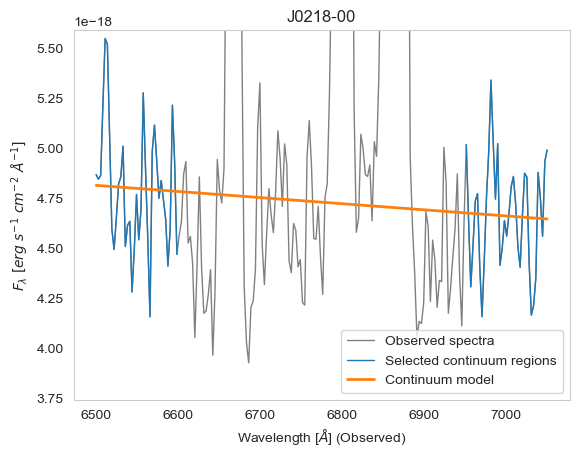

In [5]:
# Define the regions where to fit the continuum
w1c = 6500 * u.angstrom #segment on the left
w2c = 6600 * u.angstrom
w3c = 6950 * u.angstrom #on the right
w4c = 7050 * u.angstrom

# Fit the continuum and estimate the noise
wlimits_cont = ([w1c,w2c],[w3c,w4c])
mask_cont = (wave > w1c) & (wave < w4c)
poly_cont,noise=fit_continuum(wave,flux,wlimits_cont)

# For plotting the chosen region of continuum
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]
flux_cont_model = poly_cont(wave_cont)
mask_cont_blue = (wave > w1c) & (wave < w2c)   
mask_cont_red = (wave > w3c) & (wave < w4c)

sns.set_palette('tab10',8)
xlabel=r"Wavelength [$\AA$] (Observed)"
ylabel='$F_\lambda$ $[erg\ s^{-1}\ cm^{-2}\ \AA^{-1}]$'
plt.plot(wave_cont,flux_cont*norm,linewidth=1,color="gray",label="Observed spectra")
plt.plot(wave[mask_cont_blue],flux[mask_cont_blue]*norm,label='Selected continuum regions',color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave[mask_cont_red],flux[mask_cont_red]*norm,color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave_cont,flux_cont_model*norm,label='Continuum model',color=sns.color_palette('tab10')[1],linewidth=2)
plt.legend()
plt.grid()
plt.ylim(np.median(flux_cont*norm.value)-0.21*np.median(flux_cont*norm.value),np.median(flux_cont*norm.value)+0.18*np.median(flux_cont*norm.value))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(tgt_name)

### Modeling of the [OIII]4959 emission line

In [6]:
# Define the line region
w1 = 6765 *u.angstrom #below [OIII]4959
w2 = 6835 *u.angstrom #above [OIII]4959
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

# Define the initial parameters for the model
wave_O3r = 5007*(1+redshift)*u.angstrom
wave_O3b = 4959*(1+redshift)*u.angstrom
stddev_n = 5*u.angstrom #sigma
amp_O3b = flux_reg_nocont[np.argmin(abs(wave_reg-wave_O3b))] #flux of the nearest point to the central position of the line (wave_o3)

In [7]:
# Choosing the gaussian components for each emission line
c1 = models.Gaussian1D(amplitude=amp_O3b, mean=wave_O3b, stddev=stddev_n,name='[OIII]4959n1')
c2 = models.Gaussian1D(amplitude=amp_O3b/2, mean=wave_O3b, stddev=2*stddev_n,name='[OIII]4959n2')

# Conditions to the gaussian amplitudes
c1.amplitude.bounds=(0,None)
c2.amplitude.bounds=(0,None)

line_combo = c1 + c2 #Gaussians to fit



Initial parameters of the parametric model [2.83045576e+00 6.80324483e+03 4.76428647e+00 8.88512084e-01
 6.79734541e+03 5.92422850e+00]


Initial velocities of the non-parametric analysis [6802.51898656  644.63149699  -69.40865907 -488.44807782  349.63075969
  -27.81389471  -50.95766582]


 -------- 


 Executing simulation
[OIII]4959n1
4.556238494367429e-16 erg / (A cm2 s) 1.0097592716201689 1.2081318556457077e-17 erg / (A cm2 s)
 Center= 6802.95 +/- 0.84
 FWHM= 5.065e+02 km / s +/- 4.347e+01 km / s
 Flux= 4.556e-16 erg / (A cm2 s) +/- 7.324e-17 Angstrom erg / (A cm2 s)
 EW= 37.35 +/- 6.00 Angstrom
 
[OIII]4959n2
1.1735048869652071e-16 erg / (A cm2 s) 1.0101170139128484 1.2081318556457077e-17 erg / (A cm2 s)
 Center= 6797.69 +/- 2.97
 FWHM= 6.148e+02 km / s +/- 8.669e+01 km / s
 Flux= 1.174e-16 erg / (A cm2 s) +/- 1.151e-16 Angstrom erg / (A cm2 s)
 EW= 9.62 +/- 9.43 Angstrom
 
Reduced chi-squared:  32.58369891741261




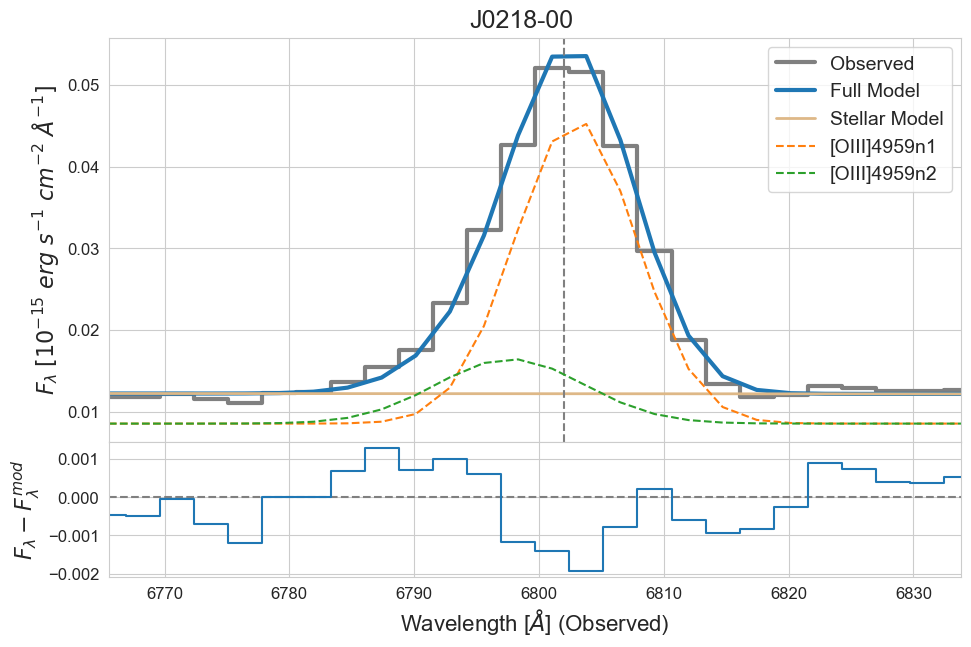

In [8]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit_4959,line_combo_error_4959,line_tab,chi2_4959,blueshift_4959,eblueshift_4959, nonpar_fit_4959, nonpar_error_4959,\
outflow_fit_4959, outflow_error_4959, outflow_blue_fit_4959, outflow_blue_error_4959, outflow_red_fit_4959, outflow_red_error_4959,\
params_simul_4959, params_simul_nonpar_4959 = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2_4959)
print('\n')

#### Simulated distributions

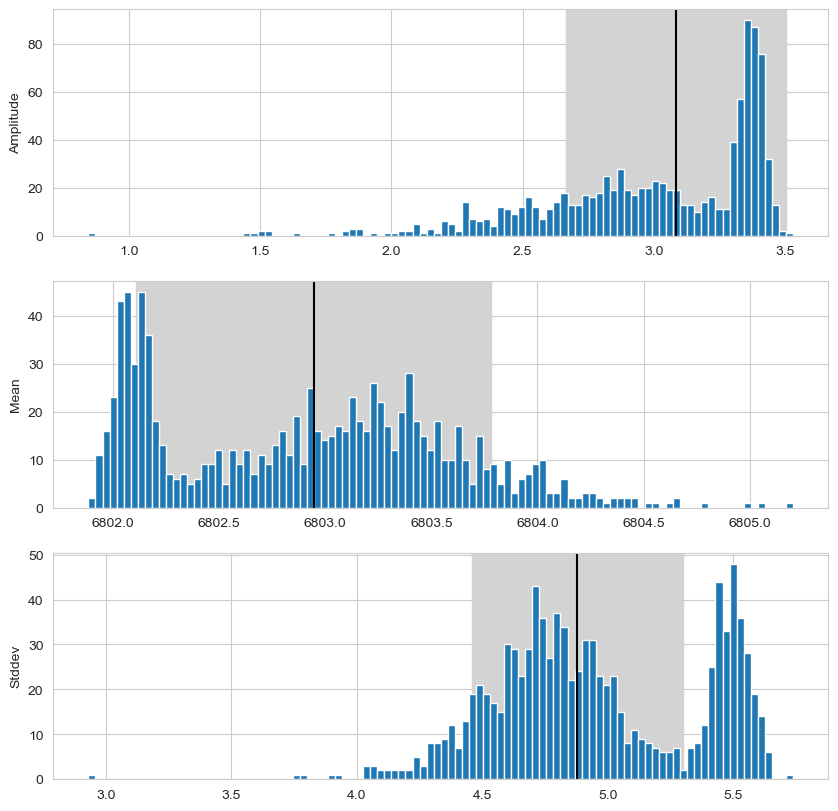

In [9]:
# Checking the simulated normal distributions for the parameters of the first modeled component
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.axvspan(line_combo_fit_4959.parameters[0]-line_combo_error_4959.parameters[0],line_combo_fit_4959.parameters[0]+line_combo_error_4959.parameters[0],color='lightgrey')
ax1.hist(params_simul_4959[0],bins=100)
ax1.axvline(line_combo_fit_4959.parameters[0],color='black')
ax1.set_ylabel('Amplitude')

ax2.axvspan(line_combo_fit_4959.parameters[1]-line_combo_error_4959.parameters[1],line_combo_fit_4959.parameters[1]+line_combo_error_4959.parameters[1],color='lightgrey')
ax2.hist(params_simul_4959[1],bins=100)
ax2.axvline(line_combo_fit_4959.parameters[1],color='black')
ax2.set_ylabel('Mean')

ax3.axvspan(line_combo_fit_4959.parameters[2]-line_combo_error_4959.parameters[2],line_combo_fit_4959.parameters[2]+line_combo_error_4959.parameters[2],color='lightgrey')
ax3.hist(params_simul_4959[2],bins=100)
ax3.axvline(line_combo_fit_4959.parameters[2],color='black')
ax3.set_ylabel('Stddev')
plt.show()


Text(0, 0.5, 'Asymmetry')

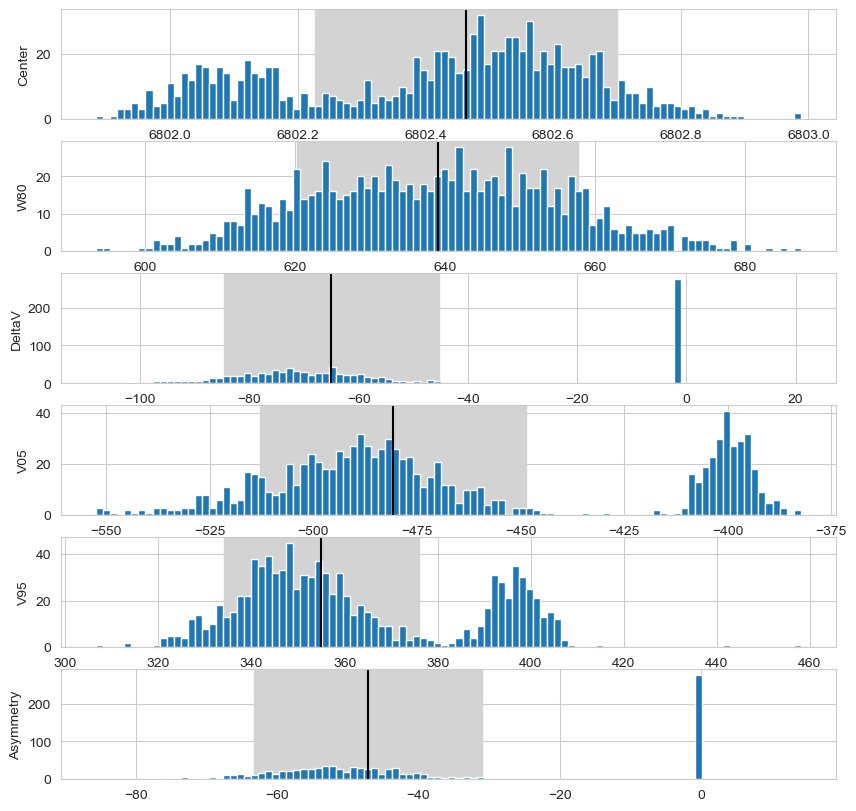

In [10]:
# Checking the simulated normal distributions for the non-parametric velocites
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,10))
ax1.axvspan(nonpar_fit_4959[0]-nonpar_error_4959[0],nonpar_fit_4959[0]+nonpar_error_4959[0],color='lightgrey')
ax1.hist(params_simul_nonpar_4959[0],bins=100)
ax1.axvline(nonpar_fit_4959[0],color='black')
ax1.set_ylabel('Center')

ax2.axvspan(nonpar_fit_4959[1]-nonpar_error_4959[1],nonpar_fit_4959[1]+nonpar_error_4959[1],color='lightgrey')
ax2.hist(params_simul_nonpar_4959[1],bins=100)
ax2.axvline(nonpar_fit_4959[1],color='black')
ax2.set_ylabel('W80')

ax3.axvspan(nonpar_fit_4959[2]-nonpar_error_4959[2],nonpar_fit_4959[2]+nonpar_error_4959[2],color='lightgrey')
ax3.hist(params_simul_nonpar_4959[2],bins=100)
ax3.axvline(nonpar_fit_4959[2],color='black')
ax3.set_ylabel('DeltaV')

ax4.axvspan(nonpar_fit_4959[3]-nonpar_error_4959[3],nonpar_fit_4959[3]+nonpar_error_4959[3],color='lightgrey')
ax4.hist(params_simul_nonpar_4959[3],bins=100)
ax4.axvline(nonpar_fit_4959[3],color='black')
ax4.set_ylabel('V05')

ax5.axvspan(nonpar_fit_4959[4]-nonpar_error_4959[4],nonpar_fit_4959[4]+nonpar_error_4959[4],color='lightgrey')
ax5.hist(params_simul_nonpar_4959[4],bins=100)
ax5.axvline(nonpar_fit_4959[4],color='black')
ax5.set_ylabel('V95')

ax6.axvspan(nonpar_fit_4959[6]-nonpar_error_4959[6],nonpar_fit_4959[6]+nonpar_error_4959[6],color='lightgrey')
ax6.hist(params_simul_nonpar_4959[6],bins=100)
ax6.axvline(nonpar_fit_4959[6],color='black')
ax6.set_ylabel('Asymmetry')

#### Parametric model of the [OIII]4959 emission line

In [11]:
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par_0 = table_add_model(line_combo_fit_4959,table)
table_par_0.add_column(blueshift_4959,name='Blueshift')
table_par_0.add_column(eblueshift_4959,name='eBlueshift')

In [12]:
table_par_0

LineID,Center,eCenter,Flux,eFlux,FWHM,eFWHM,EW,eEW,Blueshift,eBlueshift
str12,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
[OIII]4959n1,6802.9453,0.83790725,4.5562384e-16,7.3243336e-17,506.45734,43.46589,37.348595,6.003934,40.56369143113341,36.94317112062254
[OIII]4959n2,6797.6924,2.9674633,1.1735049e-16,1.1509294e-16,614.7569,86.68829,9.616098,9.431107,-191.02231927251603,130.83489011756959


#### Non parametric analysis of the [OIII]4959 emission line

In [13]:
table_nonpar_0 = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asimetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar_0.add_row(np.append(tgt_name,nonpar_fit_4959))
table_nonpar_0.add_columns(np.array(nonpar_error_4959,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsimetry'))

In [14]:
table_nonpar_0

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asimetry,eAsimetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,6802.464,0.23685504,638.9961,18.690825,-65.00904,19.737062,-480.72586,32.061726,355.00427,20.968733,-25.794815,9.262903,-47.173004,16.105284


### Model for both the [OIII]5007 emission lines



#### Parametric model

In [15]:
# Define the both lines region
w1 = 4925*(1+redshift) *u.angstrom #below [OIII]4959
w2 = 5045*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

In [16]:
# Models for both emission lines
mean_5007=table_par_0['Center'][0]*5006.843/4958.911
stddev_5007=table_par_0['FWHM'][0]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007)
amp_5007=3*table_par_0['Flux'][0]/(np.sqrt(2*np.pi)*stddev_5007*norm/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007b=table_par_0['Center'][1]*5006.843/4958.911
stddev_5007b=table_par_0['FWHM'][1]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007b)
amp_5007b=3*table_par_0['Flux'][1]/(np.sqrt(2*np.pi)*stddev_5007b*norm/(u.erg/(u.A*u.s*u.cm*u.cm)))

c1 = models.Gaussian1D(amplitude=amp_5007, mean=mean_5007, stddev=stddev_5007,name='[OIII]5007n1')
c2 = models.Gaussian1D(name='[OIII]4959n1')
c3 = models.Gaussian1D(amplitude=amp_5007b, mean=mean_5007b, stddev=stddev_5007b,name='[OIII]5007n2') #broad=ancha
c4 = models.Gaussian1D(name='[OIII]4959n2') 

# We force the [OIII]5007 line to have the values obtained by the previous fit
c1.stddev.fixed= True
c1.amplitude.fixed= True
c1.mean.fixed = True
c3.stddev.fixed= True
c3.amplitude.fixed= True
c3.mean.fixed = True

#And we force the [OIII]4959 line to verify the relations
c2.mean.tied = tie_center_OIIIn1 #solidarity
c2.stddev.tied = tie_stddevn_OIIIn1 #same kinematic fwhm
c2.amplitude.tied = tie_ampl_OIIIn1 #ratio between the line (amplitude)
c4.mean.tied = tie_center_OIIIn2 #solidarity 
c4.stddev.tied = tie_stddevn_OIIIn2 #same kinematic fwhm
c4.amplitude.tied = tie_ampl_OIIIn2 #ratio between the line (amplitude)

line_combo = c1 + c2 + c3 + c4 #Gaussians to fit



Initial parameters of the parametric model [2.36647784e+01 6.86870144e+03 4.92587420e+00 7.88825948e+00
 6.80294531e+03 4.87871734e+00 5.02522860e+00 6.86339773e+03
 5.97459384e+00 1.67507620e+00 6.79769238e+03 5.91739728e+00]


Initial velocities of the non-parametric analysis [6868.19675152  617.06521268  -46.23586892 -447.01741513  354.54567729
  -19.39276081  -31.04238939]


 -------- 


 Executing simulation
[OIII]5007n1
3.530124551471822e-15 erg / (A cm2 s) 1.0054663641080166 1.2081318556457077e-17 erg / (A cm2 s)
 Center= 6868.70 +/- 0.00
 FWHM= 5.065e+02 km / s +/- 0.000e+00 km / s
 Flux= 3.530e-15 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 290.61 +/- 0.00 Angstrom
 
[OIII]4959n1
1.165443205739537e-15 erg / (A cm2 s) 1.0097592716201689 1.2081318556457077e-17 erg / (A cm2 s)
 Center= 6802.95 +/- 0.00
 FWHM= 5.065e+02 km / s +/- 0.000e+00 km / s
 Flux= 1.165e-15 erg / (A cm2 s) +/- 0.000e+00 Angstrom erg / (A cm2 s)
 EW= 95.53 +/- 0.00 Angstrom
 
[OIII]5007n2
9

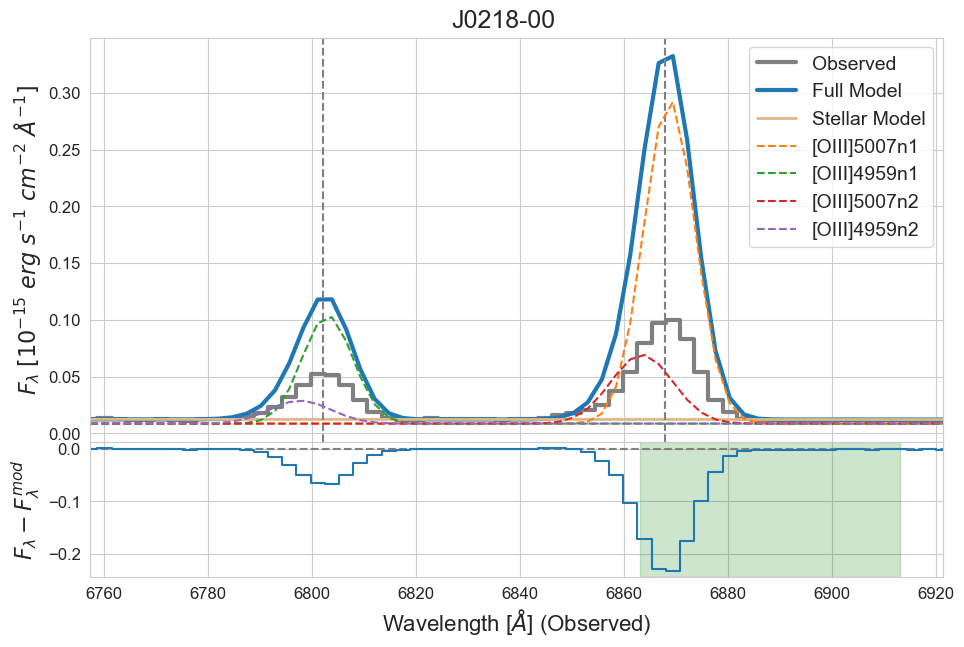

In [17]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')

In [18]:
# Table with the fitting parameters for each component of each line
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par = table_add_model(line_combo_fit,table)

# Blueshift of each component
table_par.add_column(blueshift,name='Blueshift')
table_par.add_column(eblueshift,name='eBlueshift')

# For the error estimation
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=5006.843*table_par_0['eCenter'][j]/4958.911
                table_par['eFlux'][i]=3*table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]
    if table_par['LineID'][i][:10]=='[OIII]4959':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=table_par_0['eCenter'][j]
                table_par['eFlux'][i]=table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]

# Add name
table_par.add_column(tgt_name,index=0,name='Name')

# Remove non-needed ones
table_par.remove_columns(['Center','eCenter','EW','eEW',])

# Luminosity and flux percentage
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Luminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='eLuminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Percentage')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='ePercentage')

Flux_4959=[]
Flux_5007=[]
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        Flux_5007.append(table_par['Flux'][i])

    if table_par['LineID'][i][:10]=='[OIII]4959':
        Flux_4959.append(table_par['Flux'][i])

for i in range(len(table_par['LineID'])):
    table_par['Luminosity'][i]=table_par['Flux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2
    table_par['eLuminosity'][i]=table_par['eFlux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2

    if table_par['LineID'][i][:10]=='[OIII]5007':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_5007)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_5007)

    if table_par['LineID'][i][:10]=='[OIII]4959':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_4959)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_4959)

In [19]:
table_par

Name,LineID,Flux,eFlux,FWHM,eFWHM,Blueshift,eBlueshift,Luminosity,eLuminosity,Percentage,ePercentage
str8,str12,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64
J0218-00,[OIII]5007n1,3.5301246e-15,2.1973001e-16,506.45734,43.46589,40.56369143113341,36.94317112062254,1.679968698650236e+42,1.0456841596940045e+41,0.7951906323432922,0.049496058374643326
J0218-00,[OIII]4959n1,1.1654432e-15,7.3243336e-17,506.45734,43.46589,40.56369143113341,36.94317112062254,5.546286214525222e+41,3.4856138656466816e+40,0.795190691947937,0.0499744787812233
J0218-00,[OIII]5007n2,9.092189e-16,3.4527885e-16,614.7569,86.68829,-191.02231927251603,130.83489011756959,4.3269275842921406e+41,1.6431648245800528e+41,0.204809308052063,0.07777700573205948
J0218-00,[OIII]4959n2,3.001716e-16,1.1509294e-16,614.7569,86.68829,-191.02231927251603,130.83489011756959,1.428501634621632e+41,5.477215871986239e+40,0.20480933785438538,0.07852878421545029


In [20]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/parametric.txt').to_pandas()
parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())
ascii.write(QTable.from_pandas(parametric.sort_values('Name')), 'Tables/parametric.txt', format='csv', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.2e','eLuminosity':'%8.2e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\2174204615.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())


In [21]:
table_5007 = QTable(names=('Name','LineID','Flux','eFlux','FWHM','eFWHM','Blueshift','eBlueshift','Luminosity','eLuminosity','Percentage','ePercentage'), \
           dtype=('U12','U12','f4', 'f4','f4', 'f4','f4', 'f4','f8','f8','f4', 'f4'))
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_5007.add_row(table_par[i])

# Save the results in a latex format for the 5007 line
texfile = ascii.read('Tables/parametric.tex',format='latex').to_pandas()
texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())
ascii.write(QTable.from_pandas(texparametric.sort_values('Name')), 'Tables/parametric.tex', format='latex', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.3e','eLuminosity':'%8.3e','Percentage': '%8.3f','ePercentage':'%8.3f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\1745872242.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())


#### Non-parametric analysis

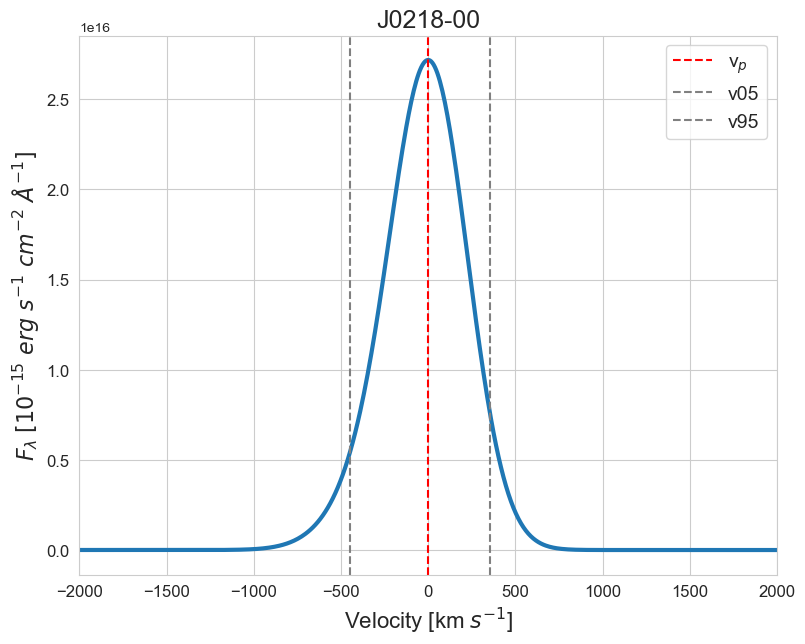

In [22]:
perform_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [23]:
table_nonpar = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asimetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar.add_row(np.append(tgt_name,nonpar_fit))
table_nonpar.add_columns(np.array(nonpar_error_4959,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsimetry'))

In [24]:
table_nonpar

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asimetry,eAsimetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,6868.197,0.23685504,617.0652,18.690825,-46.23587,19.737062,-447.01743,32.061726,354.5457,20.968733,-19.392761,9.262903,-31.042389,16.105284


In [25]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/nonparametric.txt').to_pandas()
nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(nonparametric.sort_values('Name')), 'Tables/nonparametric.txt', format='csv', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asimetry': '%8.2f','eAsimetry': '%8.2f'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\2022151897.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


In [26]:
# Save the results in a latex format
file = ascii.read('Tables/nonparametric.tex').to_pandas()
texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(texnonparametric.sort_values('Name')), 'Tables/nonparametric.tex', format='latex', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asimetry': '%8.2f','eAsimetry': '%8.2f'})


C:\Users\HP\AppData\Local\Temp\ipykernel_948\2513670923.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())


# Outflow mass, outflow mass rate and energy rate

## Giovanna's method: outflow line flux

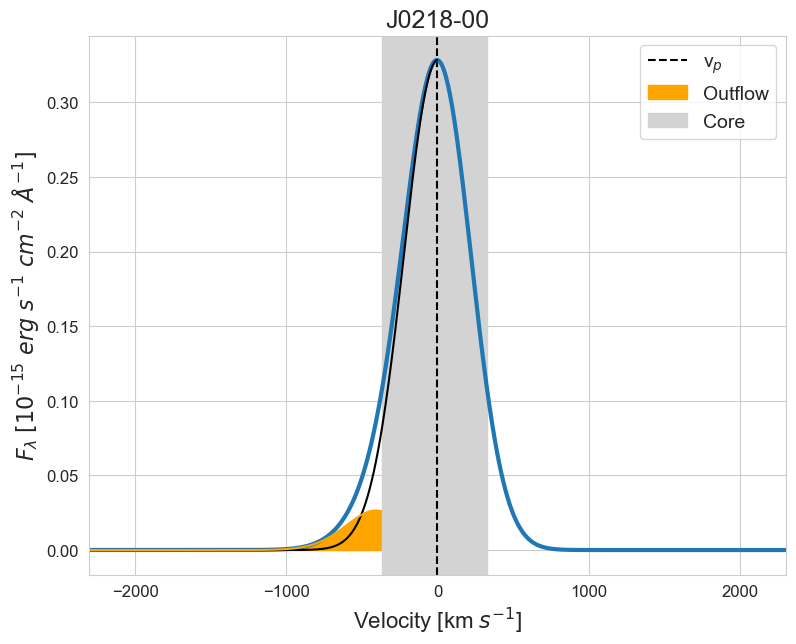

In [27]:
perform_outflow_plot(tgt_name,wave_reg,line_combo_fit,flux_norm=norm*(1+redshift)**3)

In [28]:
table_outflow = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow.add_row(np.append(tgt_name,outflow_fit))
table_outflow.add_columns(np.array(outflow_error_4959,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow.add_column(table_outflow['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow.add_column(table_outflow['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [29]:
table_outflow

Name,Foutflow,eFoutflow,Voutflow,eVoutflow,Loutflow,eLoutflow
,,,,,,
str12,float64,float64,float64,float64,float64,float64
J0218-00,1.7882477503850486e-16,8.474414938082334e-18,-526.7270456125746,29.94940626255848,8.510181942440886e+40,4.0329318442196184e+39


In [30]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_giovanna.txt').to_pandas()
outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_giovanna.tex').to_pandas()
tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\1200331943.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_948\1200331943.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())


#### Outflow energetics

In [31]:
outflow_energy,outflow_energy_errors = outflow_energetics_uncertainties(table_outflow,Nsimul=200)

In [32]:
table_outflow_energy = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy.add_row(np.append(tgt_name,outflow_energy))
table_outflow_energy.add_columns(np.array(outflow_energy_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [33]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,5.2207165,0.022358956,53.667107,0.05047311,1.0,0.0,35.37931,0.07257156,0.26971203,0.019088302


In [34]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_giovanna.txt').to_pandas()
outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_giovanna.tex').to_pandas()
tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\2348874735.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_948\2348874735.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())


## Non parametric method: v05 and v95

### V05 and v95

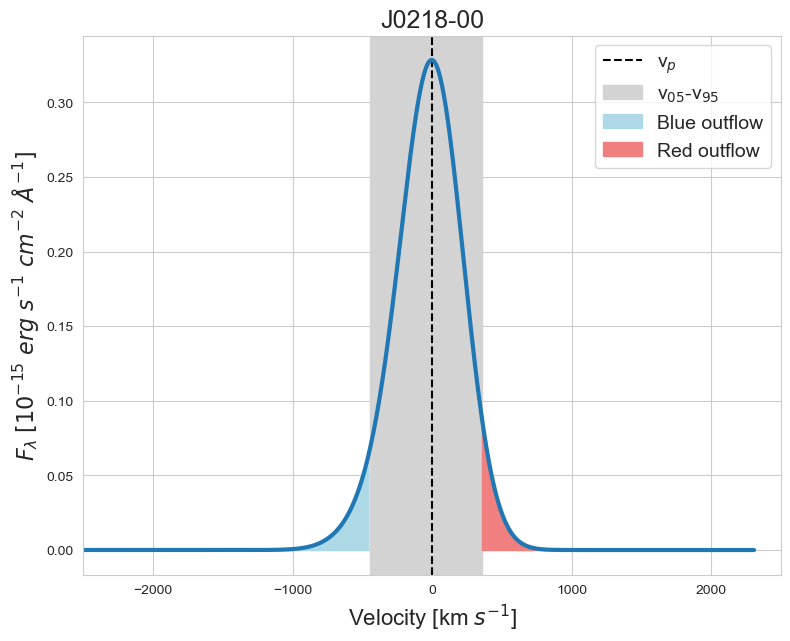

In [35]:
perform_outflow_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [36]:
table_outflow_nonpar = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_blue_fit))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_red_fit))

table_outflow_nonpar.add_column(np.array(['Blue','Red' ]),index=1,name=('Outflow'))

table_outflow_nonpar.add_columns(np.array(np.array((outflow_blue_error_4959,outflow_red_error_4959)).T,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow_nonpar.add_column(table_outflow_nonpar['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow_nonpar.add_column(table_outflow_nonpar['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [37]:
table_outflow_nonpar

Name,Outflow,eFoutflow,Foutflow,eVoutflow,Voutflow,Loutflow,eLoutflow
,,,,,,,
str12,str4,float64,float64,float64,float64,float64,float64
J0218-00,Blue,5.754969828555177e-19,2.039465971685248e-16,47.302163594549576,-550.6359566801807,9.705716940351962e+40,2.738761466565068e+38
J0218-00,Red,5.44200539049815e-19,2.1536775927381305e-16,25.58614053602076,419.72132829013157,1.0249244354208268e+41,2.589823249877498e+38


In [38]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_nonpar.txt').to_pandas()
outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_nonpar.tex').to_pandas()
tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\3637349706.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_948\3637349706.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())


#### Outflow energetics

In [39]:
outflow_energy_nonpar,outflow_energy_nonpar_errors = outflow_energetics_nonpar_uncertainties(table_outflow_nonpar,200)

In [40]:
table_outflow_energy_nonpar = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_nonpar.add_row(np.append(tgt_name,outflow_energy_nonpar))
table_outflow_energy_nonpar.add_columns(np.array(outflow_energy_nonpar_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [41]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,5.5910006,0.00077129214,53.967907,0.049162887,1.0,0.0,35.66405,0.0782161,0.57605666,0.030868936


In [42]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_nonpar.txt').to_pandas()
outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_nonpar.tex').to_pandas()
tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

C:\Users\HP\AppData\Local\Temp\ipykernel_948\4162063144.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
C:\Users\HP\AppData\Local\Temp\ipykernel_948\4162063144.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())


## Comparisson of outflow energetic methods

#### Giovanna's method (1/3 total flux)

In [43]:
table_outflow_energy

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,5.2207165,0.022358956,53.667107,0.05047311,1.0,0.0,35.37931,0.07257156,0.26971203,0.019088302


#### Non parametric method (v05 and v95)

In [44]:
table_outflow_energy_nonpar

Name,LogMof,eLogMof,LogEkin,eLogEkin,Rout,eRout,LogE.kin,eLogE.kin,M.of,eM.of
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0218-00,5.5910006,0.00077129214,53.967907,0.049162887,1.0,0.0,35.66405,0.0782161,0.57605666,0.030868936
